# Линейная регрессия

## Постановка задачи

Одна из крупных страховых компаний "СОГАЗ-МЕД" предлагает доступное медицинсткое страхование своим клиентам. Задача состоит в том, чтобы создать автоматизированную систему для оценки ежегодных медицинских расходов новых клиентов с использованием такой информации, как их возраст, пол, ИМТ (индекс массы тела), количество детей, привычки к курению и регион проживания.

Для анализа и построения автоматизированной системы используется файл CSV с данными, доступный по [ссылке](https://jovian.com/outlink?url=https%3A%2F%2Fraw.githubusercontent.com%2FJovianML%2Fopendatasets%2Fmaster%2Fdata%2Fmedical-charges.csv)

## Загрузка данных

Создаем фрейм данных Pandas, используя загруженный файл CSV и смотрим его содержимое.

In [1]:
import pandas as pd

In [2]:
medical_df = pd.read_csv('https://github.com/SerjiEvg/data-analysis/raw/main/data/medical-charges.csv', sep=',')
medical_df

,возраст,пол,ИМТ,дети,курение,регион,расходы
0,19,женский,27.900,0,да,Донецкая Народная Республика,16884.92400
1,18,мужской,33.770,1,нет,Луганская Народная Республика,1725.55230
2,28,мужской,33.000,3,нет,Луганская Народная Республика,4449.46200
3,33,мужской,22.705,0,нет,Запорожская область,21984.47061
4,32,мужской,28.880,0,нет,Запорожская область,3866.85520
...,...,...,...,...,...,...,...
1333,50,мужской,30.970,3,нет,Запорожская область,10600.54830
1334,18,женский,31.920,0,нет,Херсонская область,2205.98080
1335,18,женский,36.850,0,нет,Луганская Народная Республика,1629.83350
1336,21,женский,25.800,0,нет,Донецкая Народная Республика,2007.94500


Набор данных состоит из 1338 строк и 7 столбцов. Каждая строка набора данных содержит информацию об одном клиенте.

Наша цель — найти способ оценить значение в столбце «расходы», используя значения в других столбцах в качестве признаков. Если мы сможем сделать это на известных нам данных, то сможем спрогнозировать расходы на новых клиентов, используя такую информацию, такую как: возраст, пол, ИМТ, номер. детей, привычки курения и регион.

Проверим типы данных для каждого столбца.

In [3]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   возраст  1338 non-null   int64  
 1   пол      1338 non-null   object 
 2   ИМТ      1338 non-null   float64
 3   дети     1338 non-null   int64  
 4   курение  1338 non-null   object 
 5   регион   1338 non-null   object 
 6   расходы  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Похоже, что «возраст», «дети», «ИМТ» (индекс массы тела) и «расходы» — это числа, тогда как «пол», «курение» и «регион» — это строки (возможно, `категории`). Ни один из столбцов не содержит пропущенных значений, что экономит нам немало работы!

Вот некоторые статистические данные для числовых столбцов:

In [4]:
medical_df.describe()

,возраст,ИМТ,дети,расходы
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Диапазоны значений в числовых столбцах также кажутся разумными (никаких отрицательных возрастов!), поэтому нам не придется сильно очищать или исправлять данные. Однако столбец «расходы» кажется значительно искаженным, поскольку медиана (50-й процентиль) намного ниже максимального значения.

## Исследовательский анализ и визуализация

Давайте изучим данные, визуализируя распределение значений в некоторых столбцах набора данных и отношения между «расходами» и другими столбцами.

Для визуализации будем использовать библиотеки Matplotlib, Seaborn и Plotly. 

In [5]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Следующие настройки улучшат стиль и размер шрифта по умолчанию для наших диаграмм.

In [6]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Возраст

`Возраст` — это числовой столбец. Минимальный возраст в наборе данных — 18 лет, а максимальный — 64 года. Таким образом, мы можем визуализировать распределение возраста, используя гистограмму с 47 ячейками (по одной на каждый год) и `коробчатую диаграмму`. Мы будем использовать plotly, чтобы сделать диаграмму интерактивной, но аналогичные диаграммы можно создать с помощью Seaborn.

In [7]:
medical_df.возраст.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: возраст, dtype: float64

In [8]:
fig = px.histogram(medical_df, x='возраст', marginal='box', nbins=47, title='Распределение возраста')
fig.update_layout(bargap=0.1)
fig.show()

Распределение возрастов в наборе данных почти равномерное, по 20-30 клиентов каждого возраста, за исключением возрастов 18 и 19 лет, которых, по-видимому, вдвое больше, чем других возрастов. Равномерное распределение может быть связано с тем, что нет больших различий в количестве людей любого возраста (от 18 до 64 лет).

## Индекс массы тела

Давайте посмотрим на распределение ИМТ (индекса массы тела) клиентов, используя гистограмму и коробчатую диаграмму.

In [9]:
fig = px.histogram(medical_df, x='ИМТ', marginal='box', color_discrete_sequence=['red'], title='Распределение ИМТ')
fig.update_layout(bargap=0.1)
fig.show()

Измерения индекса массы тела, по-видимому, формируют гауссово распределение с центром вокруг значения 30 с несколькими выбросами вправо.

## Страховые расходы

Давайте визуализируем распределение «расходов», т.е. ежегодных медицинских расходов клиентов. Это столбец, который мы пытаемся предсказать. Давайте также воспользуемся категориальной колонкой «курение», чтобы различать расходы для курящих и некурящих.

In [11]:
fig = px.histogram(medical_df, x='расходы', marginal='box', color='курение', 
                   color_discrete_sequence=['green', 'grey'], title='Ежегодные медицинские расходы')
fig.update_layout(bargap=0.1)
fig.show()

Мы можем сделать следующие наблюдения из приведенного выше графика:

- Для большинства клиентов ежегодные медицинские расходы составляют менее 14 000. Только небольшая часть клиентов имеет более высокие медицинские расходы, возможно, из-за несчастных случаев, серьезных заболеваний и генетических заболеваний. Распределение следует «степенному закону».

- Существует значительная разница в медицинских расходах между курильщиками и некурящими. В то время как медиана для некурящих составляет 7300, медиана для курильщиков близка к 35 000.

## Курильщики

Давайте визуализируем распределение столбца «курильщик» (содержащего значения «да» и «нет») с помощью гистограммы.

In [ ]:
medical_df.курение.value_counts()

нет    1064
да      274
Name: курение, dtype: int64

In [13]:
px.histogram(medical_df, x='курение', color='пол', title='Курение')

Оказывается, 20% клиентов сообщили, что они курят. Мы также можем видеть, что курение является более распространенной привычкой среди мужчин. 

Посмотрев на отдельные столбцы, мы теперь можем визуализировать взаимосвязь между «затратами» (значением, которое мы хотим предсказать) и другими столбцами.

## Возраст и затраты

Давайте визуализируем взаимосвязь между «возрастом» и «затратами», используя точечную диаграмму. Каждая точка на точечной диаграмме представляет одного клиента. Мы также будем использовать значения в столбце «курение», чтобы раскрасить точки.

In [14]:
fig = px.scatter(medical_df, x='возраст', y='расходы', color='курение', 
                 opacity=0.8, hover_data=['пол'], title='Возраст и затраты')
fig.update_traces(marker_size=5)
fig.show()

Мы можем сделать следующие наблюдения из приведенной выше диаграммы:

- Общая тенденция заключается в том, что `медицинские расходы увеличиваются с возрастом`, как и следовало ожидать. Тем не менее, существуют значительные различия в каждом возрасте, и ясно, что возраст сам по себе не может быть использован для точного определения медицинских расходов.

- Мы видим `три «кластера» точек`, каждая из которых как бы образует линию с возрастающим наклоном:

1. Первый и самый большой кластер состоит в основном из предположительно «здоровых некурящих», у которых относительно низкие медицинские расходы по сравнению с другими.

2. Второй кластер состоит из курящих и некурящих. Вполне возможно, что на самом деле это две разные, но пересекающиеся группы: «некурящие с проблемами со здоровьем» и «курильщики без серьезных проблем со здоровьем».

3. Последний кластер состоит исключительно из курильщиков, предположительно курильщиков с серьезными проблемами со здоровьем, которые, возможно, связаны с курением или усугубляются им.

## ИМТ и расходы

Давайте визуализируем взаимосвязь между ИМТ (индексом массы тела) и расходами, используя другую диаграмму рассеяния. Мы снова будем использовать значения из столбца «курение», чтобы раскрасить точки.

In [15]:
fig = px.scatter(medical_df, x='ИМТ', y='расходы', color='курение', opacity=0.8, 
                 hover_data=['пол'], title='ИМТ и расходы')
fig.update_traces(marker_size=5)
fig.show()

Похоже, что для некурящих увеличение ИМТ не связано с увеличением расходов на лечение. Тем не менее, медицинские расходы, по-видимому, значительно выше для курильщиков с ИМТ выше 30.

### Корреляция

Как видно из анализа, значения в некоторых столбцах более тесно связаны со значениями в «расходах» по сравнению с другими столбцами. Например, кажется, что «возраст» и «расходы» растут вместе, а «ИМТ» и «расходы» — нет.

Эта связь часто выражается численно с использованием показателя, называемого `коэффициентом корреляции`, который можно вычислить с помощью метода `.corr` для ряда Pandas.

In [9]:
medical_df.расходы.corr(medical_df.возраст)

0.29900819333064765

In [10]:
medical_df.расходы.corr(medical_df.ИМТ)

0.19834096883362884

Чтобы вычислить `корреляцию для категориальных столбцов`, их необходимо сначала преобразовать в числовые столбцы.

In [21]:
smoker_values = {'нет': 0, 'да': 1}
smoker_numeric = medical_df.курение.map(smoker_values)
medical_df.расходы.corr(smoker_numeric)

0.787251430498477




Вот как можно интерпретировать коэффициенты корреляции ([источник](https://statisticsbyjim.com/basics/correlations)):

* **Сила**: чем больше абсолютное значение коэффициента корреляции, тем сильнее связь.

    * `Экстремальные значения -1 и 1` указывают на совершенно линейную зависимость, при которой изменение одной переменной сопровождается постоянным изменением другой. Для этих отношений все точки данных попадают на линию. На практике это встречается довольно редко.

    * `Нулевой коэффициент` означает отсутствие линейной зависимости. Когда одна переменная увеличивается, другая переменная не имеет тенденции ни к увеличению, ни к уменьшению.

    * Когда `значение находится между 0 и +1/-1`, существует связь, но не все точки попадают на линию. Когда r приближается к -1 или 1, сила связи увеличивается, и точки данных имеют тенденцию приближаться к линии.


* **Направление**: знак коэффициента корреляции представляет направление отношения.

    * `Положительные коэффициенты` указывают на то, что при увеличении значения одной переменной значение другой переменной также имеет тенденцию к увеличению. Положительные отношения создают восходящий наклон на диаграмме рассеяния.

    * `Отрицательные коэффициенты` представляют случаи, когда значение одной переменной увеличивается, а значение другой переменной имеет тенденцию к уменьшению. Негативные отношения приводят к нисходящему наклону.

Вот то же отношение, выраженное визуально ([источник](https://www.cuemath.com/data/how-to-calculate-correlation-coefficient/)):

<img src="https://i.imgur.com/3XUpDlw.png" width="360" style="background-color:white">

Коэффициент корреляции имеет следующую формулу:

<img src="https://i.imgur.com/unapugP.png" width="360">

Для DataFrame Pandas также имеется метод `.corr` для вычисления коэффициентов корреляции между всеми парами числовых столбцов.

In [11]:
medical_df.corr()

,возраст,ИМТ,дети,расходы
возраст,1.000000,0.109272,0.042469,0.299008
ИМТ,0.109272,1.000000,0.012759,0.198341
дети,0.042469,0.012759,1.000000,0.067998
расходы,0.299008,0.198341,0.067998,1.000000


Результат `.corr` называется `матрицей корреляции` и часто визуализируется с помощью тепловой карты.

Text(0.5, 1.0, 'Матрица корреляции')

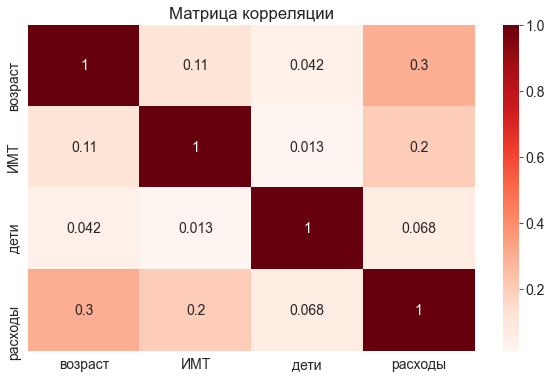

In [24]:
sns.heatmap(medical_df.corr(), cmap='Reds', annot=True)
plt.title('Матрица корреляции')

`Ошибка корреляции` и `причинно-следственная связь`: обратите внимание, что высокую корреляцию нельзя использовать для интерпретации причинно-следственной связи между функциями. Две величины $X$ и $Y$ могут быть коррелированными, если $X$ зависит от $Y$ или если $Y$ зависит от $X$, или если обе зависят от какого-либо другого фактора $Z$, и корреляция перестанет существовать, если одна из причинно-следственных связей будет нарушена. Также возможно, что $X$ и $Y$  просто кажутся коррелированными, потому что выборка слишком мала.

Хотя это может показаться очевидным, компьютеры не могут провести различие между корреляцией и причинно-следственной связью, а решения, основанные на автоматизированной системе, часто могут иметь серьезные последствия, поэтому важно изучить, почему автоматизированные системы приводят к данному результату. Выявление причинно-следственных связей требует человеческого понимания.

## Линейная регрессия с использованием одной функции

Теперь мы знаем, что столбцы «курение» и «возраст» имеют самую сильную корреляцию. Попробуем найти способ оценки величины «расходов» по ​​величине «возраста» для некурящих. Во-первых, давайте создадим фрейм данных, содержащий только данные для некурящих.

In [12]:
non_smoker_df = medical_df[medical_df.курение == 'нет']

Далее давайте визуализируем взаимосвязь между «возрастом» и «расходами».

<AxesSubplot:title={'center':'Возраст и расходы'}, xlabel='возраст', ylabel='расходы'>

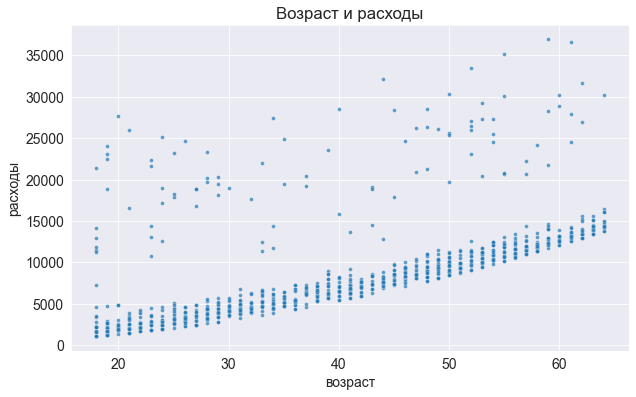

In [13]:
plt.title('Возраст и расходы')
sns.scatterplot(data=non_smoker_df, x='возраст', y='расходы', alpha=0.7, s=15)

За некоторыми исключениями, кажется, что точки образуют линию. Мы попробуем «выстроить» линию, используя эти точки, и использовать линию для прогнозирования расходов для данного возраста. Линия в координатах X и Y имеет следующую формулу:

$y = wx + b$

Линия характеризуется двумя числами: $w$ (называется "наклон") и $b$ (называется "смещение"). 

### Модель

В приведенном выше случае ось x показывает «возраст», а ось y — «сборы». Таким образом, мы предполагаем следующее соотношение между ними:

$charges = w \times age + b$

Мы попробуем определить $w$ и $b$ для строки, которая лучше всего соответствует данным. 

* Этот метод называется `линейной регрессией`, и мы называем вышеприведенное уравнение `моделью линейной регрессии`, потому что она моделирует взаимосвязь между «возрастом» и «начислениями» в виде прямой линии.

* Цифры $w$ и $b$ называются `параметрами или весами модели`.

* Значения в столбце «возраст» набора данных называются `входными данными` для модели, а значения в столбце расходов называются `«целевыми»`.

Определим вспомогательную функцию `estimate_charges`, для определения $charges$, для заданных $age$, $w$ и $b$.


In [27]:
def estimate_charges(age, w, b):
    return w * age + b

Функция `estimate_charges` является нашей самой первой моделью.

Давайте угадаем значения $w$ и $b$ чтобы использовать их для оценки величины сборов.

In [28]:
w = 50
b = 100

In [29]:
ages = non_smoker_df.возраст
estimated_charges = estimate_charges(ages, w, b)

Мы можем построить предполагаемые расходы, используя линейный график.

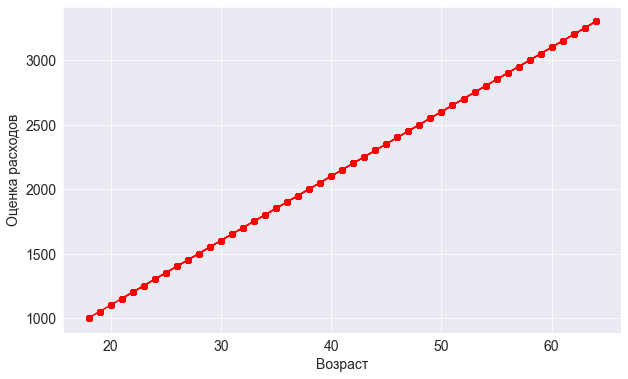

In [30]:
plt.plot(ages, estimated_charges, 'r-o')
plt.xlabel('Возраст')
plt.ylabel('Оценка расходов')

Как и ожидалось, точки лежат на прямой.

Мы можем наложить эту линию на фактические данные, чтобы посмотреть, насколько хорошо наша модель соответствует данным.

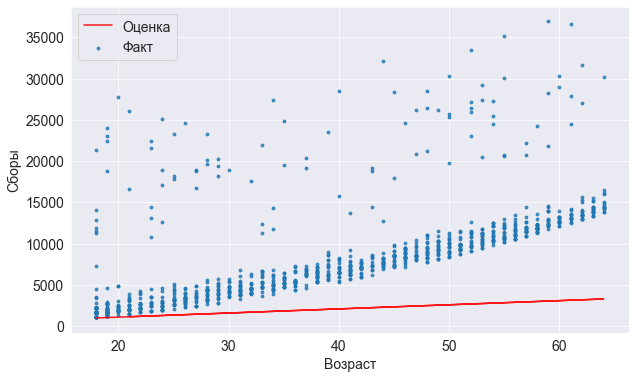

In [31]:
target = non_smoker_df.расходы

plt.plot(ages, estimated_charges, 'r', alpha=0.9)
plt.scatter(ages, target, s=8, alpha=0.8)
plt.xlabel('Возраст')
plt.ylabel('Сборы')
plt.legend(['Оценка', 'Факт'])

Ясно, что наши оценки весьма плохи, и линия не «подходит» к данным. Однако мы можем попробовать разные значения $w$ и $b$ чтобы переместить линию вокруг. Давайте определим вспомогательную функцию `try_parameters`, которая принимает `w` и `b` в качестве входных данных и создает приведенный выше график.

In [32]:
def try_parameters(w, b):
    ages = non_smoker_df.возраст
    target = non_smoker_df.расходы
    
    estimated_charges = estimate_charges(ages, w, b)
    
    plt.plot(ages, estimated_charges, 'r', alpha=0.9)
    plt.scatter(ages, target, s=8, alpha=0.8)
    plt.xlabel('Возраст')
    plt.ylabel('Сборы')
    plt.legend(['Оценка', 'Факт'])

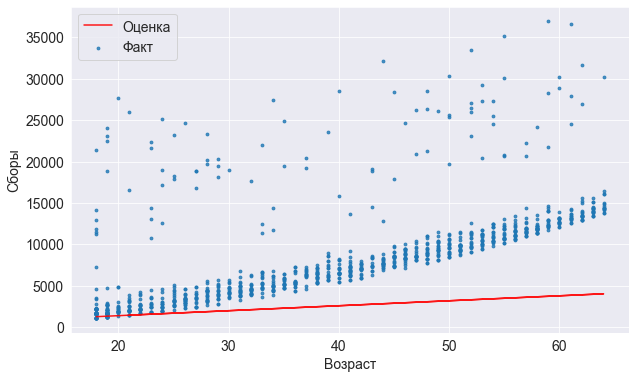

In [33]:
try_parameters(60, 200)

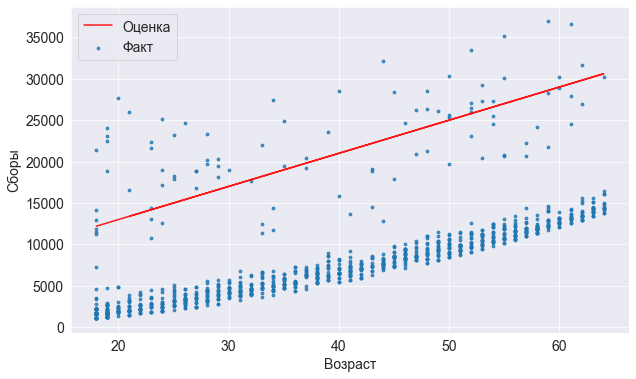

In [34]:
try_parameters(400, 5000)

По мере того, как мы меняем значения, $w$ и $b$ вручную, стараясь визуально приблизить линию к точкам, мы изучаем примерное соотношение между «возрастом» и «расходами».

Было бы неплохо, если бы компьютер мог попробовать несколько различных значений $w$ и $b$ и узнать взаимосвязь между «возрастом» и «расходами»? 

Для этого нам нужно решить пару задач:

* `Нам нужен способ численно измерить, насколько хорошо линия соответствует точкам.`

* `После того, как «мера соответствия» вычислена, нам нужен способ изменить w и b улучшить соответствие.`

Если мы сможем решить вышеупомянутые проблемы, компьютер сможет определить $w$ и $b$ наилучшую подходящую линию, начиная со случайного предположения.

## Функция потерь/затрат

Мы можем сравнить прогнозы нашей модели с фактическими целями, используя следующий метод:

* Вычислить разницу между целями и прогнозами (разницу называют `«остатком»`)

* Возвести в квадрат все элементы разностной матрицы, чтобы удалить отрицательные значения.

* Вычислить среднее значение элементов в результирующей матрице.

* Извлечь квадратный корень из результата.

Результатом является одно число, известное как `среднеквадратическая ошибка (RMSE)`. Приведенное выше описание можно сформулировать математически следующим образом:



<img src="https://i.imgur.com/WCanPkA.png" width="360">

Геометрически остатки можно представить следующим образом:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Давайте определим функцию для вычисления RMSE.

In [35]:
import numpy as np

In [36]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

Давайте вычислим RMSE для нашей модели с набором выборок весов.

In [37]:
w = 50
b = 100

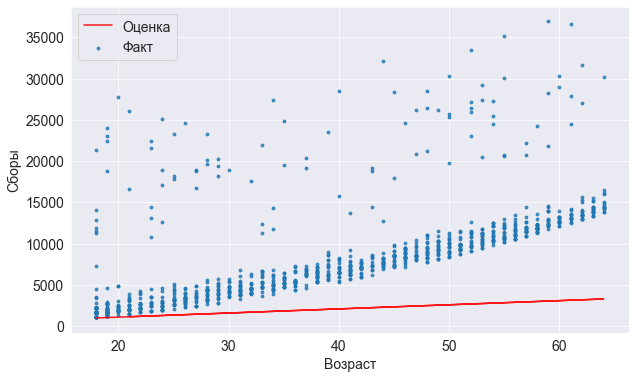

In [38]:
try_parameters(w, b)

In [39]:
targets = non_smoker_df['расходы']
predicted = estimate_charges(non_smoker_df.возраст, w, b)

In [40]:
rmse(targets, predicted)

8461.949562575488

Вот как мы можем интерпретировать приведенное выше число: `В среднем каждый элемент в прогнозе отличается от фактической цели на 8461.`

Результат называется `потерями`, потому что он показывает, насколько плохо модель предсказывает целевые переменные. Он представляет собой потерю информации в модели: `чем меньше потеря, тем лучше модель.`

Давайте изменим  функцию `try_parameters` таким образом, чтобы она также отображала потери.

In [41]:
def try_parameters(w, b):
    ages = non_smoker_df.возраст
    target = non_smoker_df.расходы
    predictions = estimate_charges(ages, w, b)
    
    plt.plot(ages, predictions, 'r', alpha=0.9)
    plt.scatter(ages, target, s=8, alpha=0.8)
    plt.xlabel('Возраст')
    plt.ylabel('Сборы')
    plt.legend(['Оценка', 'Факт'])
    
    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  8461.949562575488


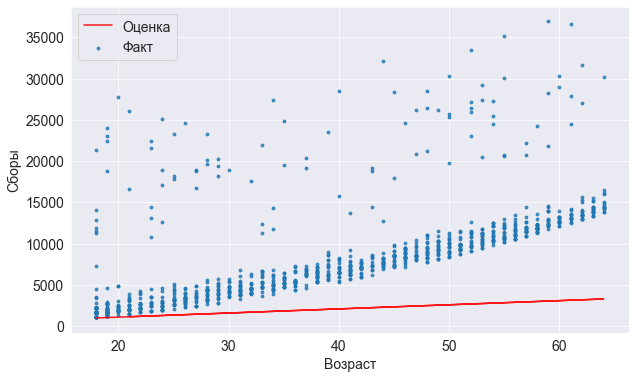

In [42]:
try_parameters(50, 100)

## Оптимизатор

Далее нам нужна стратегия изменения весов $w$, $b$ и уменьшения потерь для улучшения «подгонки» линии к данным.

* `Метод наименьших квадратов`: лучше для небольших наборов данных

* `Стохастический градиентный спуск`: лучше для больших наборов данных

Оба они имеют одну и ту же цель: минимизировать потери, однако, в то время как обычный метод наименьших квадратов напрямую вычисляет наилучшие значения для $w$ и $b$, с использованием матричных операций, то градиентный спуск использует итеративный подход, начиная со случайных значений $w$ и $b$ постепенно улучшая их с помощью производных.

## Линейная регрессия с использованием Scikit-learn

На практике никогда не придется реализовывать любой из вышеперечисленных методов самостоятельно. Можете использовать библиотеку scikit-learn.

Давайте воспользуемся  классом LinearRegression из scikit-learn, чтобы найти наиболее подходящую модель для «возраста» и «расходов», используя обычный метод оптимизации методом наименьших квадратов.

In [14]:
from sklearn.linear_model import LinearRegression

Сначала мы создаем новый объект модели.

In [15]:
model = LinearRegression()

Затем мы можем использовать  метод `fit` модели, чтобы найти линию наилучшего соответствия для входных данных и целей.

In [16]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data
    
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary
    
    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : returns an instance of self.



Ввод X должен быть двумерным массивом, поэтому нам нужно передать кадр данных вместо одного столбца.

In [46]:
inputs = non_smoker_df[['возраст']]
targets = non_smoker_df.расходы
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


Давайте подгоним модель к данным.

In [47]:
model.fit(inputs, targets)

LinearRegression()

Теперь мы можем делать прогнозы, используя модель. Давайте попробуем спрогнозировать сборы для возрастов 23, 37 и 61 года.

In [48]:
model.predict(np.array([[23], 
                        [37], 
                        [61]]))

array([ 4055.30443855,  7796.78921819, 14210.76312614])

Давайте вычислим прогнозы для всего набора входных данных

In [49]:
predictions = model.predict(inputs)

In [50]:
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

Давайте вычислим потери RMSE, чтобы оценить модель.

In [51]:
rmse(targets, predictions)

4662.505766636392

Похоже, что наш прогноз в среднем отличается на 4000, что неплохо, учитывая тот факт, что есть несколько выбросов.

Параметры модели хранятся в свойствах `coef_` и `intercept_`.

In [52]:
# w
model.coef_

array([267.24891283])

In [53]:
# b
model.intercept_

-2091.420556565079

Давайте визуализируем линию, созданную вышеуказанными параметрами.

RMSE Loss:  4662.505766636392


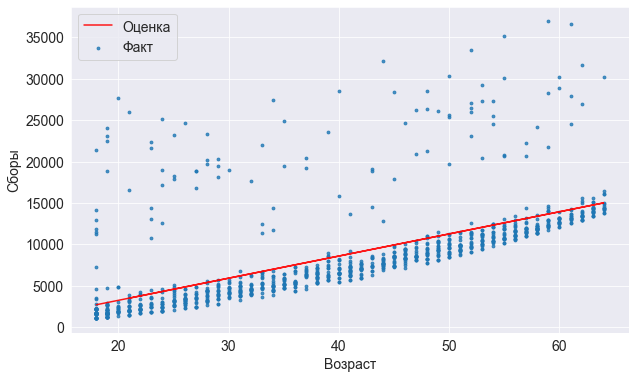

In [54]:
try_parameters(model.coef_, model.intercept_)

Действительно, линия проходит довольно близко к точкам. Он находится немного выше группы точек, потому что также пытается учесть выбросы.

## Машинное обучение

Мы только что обучили свою первую модель машинного обучения! 

`Машинное обучение` — это просто процесс вычисления наилучших параметров для моделирования взаимосвязи между некоторыми функциями и целями.

Каждая проблема машинного обучения состоит из трех компонентов:

1. Модель

2. Функция стоимости

3. Оптимизатор

Вот как можно визуализировать взаимосвязь между этими тремя компонентами:

<img src="https://i.imgur.com/oiGQFJ9.png" width="480">

Как мы видели выше, для обучения модели машинного обучения с используется scikit-learn.

In [57]:
# Create inputs and targets
inputs, targets = non_smoker_df[['возраст']], non_smoker_df['расходы']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Потери:', loss)

Потери: 4662.505766636392


## Линейная регрессия с использованием нескольких функций

До сих пор мы использовали функцию «возраст» для оценки «расходов». Добавить еще одну функцию, такую ​​как «ИМТ», довольно просто. Мы просто предполагаем следующее соотношение:

$charges = w_1 \times age + w_2 \times bmi + b$

Нам нужно изменить только одну строку кода, чтобы включить ИМТ.

In [58]:
# Create inputs and targets
inputs, targets = non_smoker_df[['возраст', 'ИМТ']], non_smoker_df['расходы']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Потери:', loss)

Потери: 4662.312835461298


Как видите, добавление ИМТ не сильно снижает потери, поскольку ИМТ имеет очень слабую корреляцию с расходами, особенно для некурящих.

In [61]:
non_smoker_df.расходы.corr(non_smoker_df.ИМТ)

0.08403654312833272

In [62]:
fig = px.scatter(non_smoker_df, x='ИМТ', y='расходы', title='ИМТ и расходы')
fig.update_traces(marker_size=5)
fig.show()

Мы также можем визуализировать взаимосвязь между всеми тремя переменными: «возраст», «ИМТ» и «расходы», используя `трехмерную диаграмму рассеивания`.

In [63]:
fig = px.scatter_3d(non_smoker_df, x='возраст', y='ИМТ', z='расходы')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()

Можно заметить, что интерпретировать 3D-диаграмму рассеяния сложнее, чем 2D-диаграмму рассеяния. По мере добавления дополнительных функций становится невозможным визуализировать все функции сразу, поэтому мы используем такие меры, как корреляция и потери.

Давайте также проверим параметры модели.

In [64]:
model.coef_, model.intercept_

(array([266.87657817,   7.07547666]), -2293.6320906488654)

Очевидно, что ИМТ имеет гораздо меньший вес. Он имеет крошечный вклад, да и то, вероятно, случайно. Важно помнить об этом: нельзя найти взаимосвязь, которой не существует, независимо от того, какой метод машинного обучения или алгоритм оптимизации применяется.

Давайте сделаем еще один шаг и добавим последний числовой столбец: «дети», который, кажется, имеет некоторую корреляцию с «расходы».

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + b$

In [66]:
non_smoker_df.расходы.corr(non_smoker_df.дети)

0.13892870453542203

In [67]:
fig = px.strip(non_smoker_df, x='дети', y='расходы', title= "Кол-во детей и расходы")
fig.update_traces(marker_size=4, marker_opacity=0.7)
fig.show()

In [68]:
# Create inputs and targets
inputs, targets = non_smoker_df[['возраст', 'ИМТ', 'дети']], non_smoker_df['расходы']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Потери:', loss)

Потери: 4608.470405038245


Опять же, мы не видим большого снижения потерь, хотя они больше, чем в случае с ИМТ.

## Использование категориальных признаков для машинного обучения

До сих пор мы использовали только числовые столбцы, поскольку мы можем выполнять вычисления только с числами. Если бы мы могли использовать категориальные столбцы, такие как «курение», мы могли бы обучить одну модель для всего набора данных.

Чтобы использовать категориальные столбцы, нам просто нужно преобразовать их в числа. Для этого есть три распространенных метода:

1. Если категориальный столбец имеет только две категории (это называется `бинарной категорией`), то мы можем заменить их значения на 0 и 1.

2. Если категориальный столбец имеет более 2 категорий, мы можем выполнить однократное кодирование, т.е. создать новый столбец для каждой категории с 1 и 0.

3. Если категории имеют естественный порядок (например, холодный, нейтральный, теплый, горячий), то их можно преобразовать в числа (например, 1, 2, 3, 4) с сохранением порядка. Они называются `ординалами`.




### Бинарные категории


Категория «курение» имеет всего два значения «да» и «нет». Давайте создадим новый столбец «smoker_code», содержащий 0 для «нет» и 1 для «да».

<AxesSubplot:xlabel='курение', ylabel='расходы'>

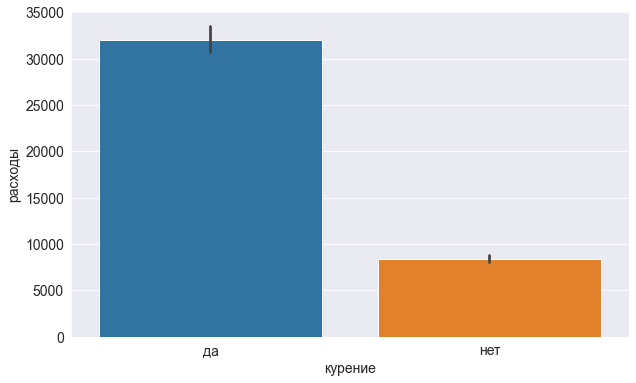

In [69]:
sns.barplot(data=medical_df, x='курение', y='расходы')

In [70]:
smoker_codes = {'нет': 0, 'да': 1}
medical_df['smoker_code'] = medical_df.курение.map(smoker_codes)

In [71]:
medical_df.расходы.corr(medical_df.smoker_code)

0.787251430498477

In [72]:
medical_df

,возраст,пол,ИМТ,дети,курение,регион,расходы,smoker_code
0,19,женский,27.900,0,да,Донецкая Народная Республика,16884.92400,1
1,18,мужской,33.770,1,нет,Луганская Народная Республика,1725.55230,0
2,28,мужской,33.000,3,нет,Луганская Народная Республика,4449.46200,0
3,33,мужской,22.705,0,нет,Запорожская область,21984.47061,0
4,32,мужской,28.880,0,нет,Запорожская область,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,мужской,30.970,3,нет,Запорожская область,10600.54830,0
1334,18,женский,31.920,0,нет,Херсонская область,2205.98080,0
1335,18,женский,36.850,0,нет,Луганская Народная Республика,1629.83350,0
1336,21,женский,25.800,0,нет,Донецкая Народная Республика,2007.94500,0


Теперь мы можем использовать столбец `smoker_df` для линейной регрессии.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + b$

In [73]:
# Create inputs and targets
inputs, targets = medical_df[['возраст', 'ИМТ', 'дети', 'smoker_code']], medical_df['расходы']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Потери:', loss)

Потери: 6056.439217188077


Потери уменьшаются от 11355 до 6056, почти на 50%! Это важный урок: `никогда не игнорируйте категориальные данные.`

Попробуем также добавить столбец «пол».

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + b$

<AxesSubplot:xlabel='пол', ylabel='расходы'>

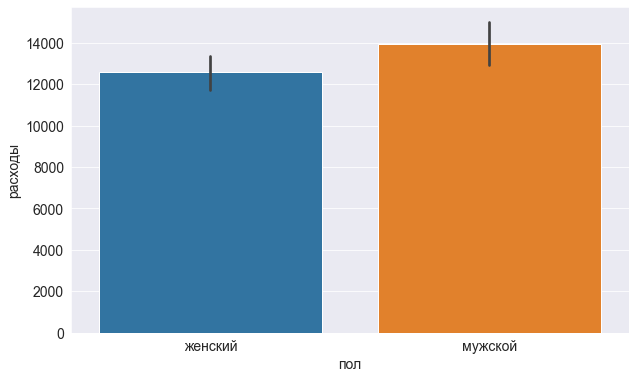

In [74]:
sns.barplot(data=medical_df, x='пол', y='расходы')

In [75]:
sex_codes = {'женский': 0, 'мужской': 1}

In [76]:
medical_df['sex_code'] = medical_df.пол.map(sex_codes)

In [77]:
medical_df.расходы.corr(medical_df.sex_code)

0.05729206220202535

In [78]:
# Create inputs and targets
inputs, targets = medical_df[['возраст', 'ИМТ', 'дети', 'smoker_code', 'sex_code']], medical_df['расходы']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Потери:', loss)

Потери: 6056.100708754539


Как и следовало ожидать, это оказывает существенное влияние на потери.


### Горячее кодирование

Столбец «регион» содержит 4 значения, поэтому нам нужно использовать горячее кодирование и создать новый столбец для каждого региона.

![](https://i.imgur.com/n8GuiOO.png)


<AxesSubplot:xlabel='регион', ylabel='расходы'>

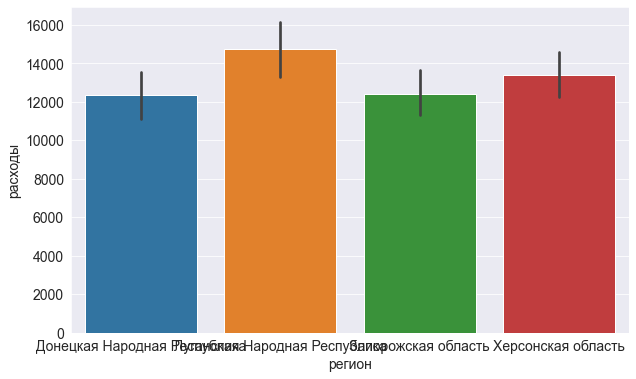

In [79]:
sns.barplot(data=medical_df, x='регион', y='расходы')

In [80]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['регион']])
enc.categories_

[array(['Донецкая Народная Республика', 'Запорожская область',
        'Луганская Народная Республика', 'Херсонская область'],
       dtype=object)]

In [81]:
one_hot = enc.transform(medical_df[['регион']]).toarray()
one_hot

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [82]:
medical_df[['Донецкая Народная Республика', 'Запорожская область', 'Луганская Народная Республика', 'Херсонская область']] = one_hot

In [83]:
medical_df

,возраст,пол,ИМТ,дети,курение,регион,расходы,smoker_code,sex_code,Донецкая Народная Республика,Запорожская область,Луганская Народная Республика,Херсонская область
0,19,женский,27.900,0,да,Донецкая Народная Республика,16884.92400,1,0,1.0,0.0,0.0,0.0
1,18,мужской,33.770,1,нет,Луганская Народная Республика,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,мужской,33.000,3,нет,Луганская Народная Республика,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,мужской,22.705,0,нет,Запорожская область,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,мужской,28.880,0,нет,Запорожская область,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,мужской,30.970,3,нет,Запорожская область,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,женский,31.920,0,нет,Херсонская область,2205.98080,0,0,0.0,0.0,0.0,1.0
1335,18,женский,36.850,0,нет,Луганская Народная Республика,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,женский,25.800,0,нет,Донецкая Народная Республика,2007.94500,0,0,1.0,0.0,0.0,0.0


Давайте включим столбцы регионов в нашу модель линейной регрессии.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [84]:
# Create inputs and targets
input_cols = ['возраст', 'ИМТ', 'дети', 'smoker_code', 'sex_code', 
'Донецкая Народная Республика', 'Запорожская область', 'Луганская Народная Республика', 'Херсонская область']
inputs, targets = medical_df[input_cols], medical_df['расходы']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Потери:', loss)

Потери: 6041.679651174454


Опять же, это приводит к довольно небольшому снижению потерь. 

## Улучшения модели

Давайте обсудим и применим еще несколько улучшений к нашей модели.

### Масштабирование функций

Напомним, что из-за нормативных требований нам также необходимо объяснить обоснование прогнозов нашей модели.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

Чтобы сравнить важность каждой функции в модели, нашим первым порывом может быть сравнение их весов.

In [85]:
model.coef_

array([  256.85635254,   339.19345361,   475.50054515, 23848.53454191,
        -131.3143594 ,  -373.04175627,   234.0453356 ,  -448.01281436,
         587.00923503])

In [86]:
model.intercept_

-12525.54781119545

In [87]:
weights_df = pd.DataFrame({
    'feature': np.append(input_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df

,feature,weight
0,возраст,256.856353
1,ИМТ,339.193454
2,дети,475.500545
3,smoker_code,23848.534542
4,sex_code,-131.314359
5,Донецкая Народная Республика,-373.041756
6,Запорожская область,234.045336
7,Луганская Народная Республика,-448.012814
8,Херсонская область,587.009235
9,1,-12525.547811


Хотя кажется, что ИМТ и «Херсонская область» имеют более высокий вес, чем возраст, имейте в виду, что диапазон значений для ИМТ ограничен (от 15 до 40), а столбец «Херсонская область» принимает только значения 0 и 1.

Поскольку разные столбцы имеют разные диапазоны, мы сталкиваемся с двумя проблемами:

1. `Мы не можем сравнить веса разных столбцов, чтобы определить, какие функции важны.`

2. `Столбец с большим диапазоном входных данных может непропорционально повлиять на потери и доминировать в процессе оптимизации.`

По этой причине общепринятой практикой является масштабирование (или стандартизация) значений в числовом столбце путем вычитания среднего значения и деления на стандартное отклонение.

![](https://i.imgur.com/dT5fLFI.png)

Мы можем применить масштабирование, используя класс StandardScaler из scikit-learn.

In [88]:
medical_df

,возраст,пол,ИМТ,дети,курение,регион,расходы,smoker_code,sex_code,Донецкая Народная Республика,Запорожская область,Луганская Народная Республика,Херсонская область
0,19,женский,27.900,0,да,Донецкая Народная Республика,16884.92400,1,0,1.0,0.0,0.0,0.0
1,18,мужской,33.770,1,нет,Луганская Народная Республика,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,мужской,33.000,3,нет,Луганская Народная Республика,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,мужской,22.705,0,нет,Запорожская область,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,мужской,28.880,0,нет,Запорожская область,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,мужской,30.970,3,нет,Запорожская область,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,женский,31.920,0,нет,Херсонская область,2205.98080,0,0,0.0,0.0,0.0,1.0
1335,18,женский,36.850,0,нет,Луганская Народная Республика,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,женский,25.800,0,нет,Донецкая Народная Республика,2007.94500,0,0,1.0,0.0,0.0,0.0


In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
numeric_cols = ['возраст', 'ИМТ', 'дети'] 
scaler = StandardScaler()
scaler.fit(medical_df[numeric_cols])

StandardScaler()

In [91]:
scaler.mean_

array([39.20702541, 30.66339686,  1.09491779])

In [92]:
scaler.var_

array([197.25385199,  37.16008997,   1.45212664])

Теперь мы можем масштабировать данные следующим образом:

In [93]:
scaled_inputs = scaler.transform(medical_df[numeric_cols])
scaled_inputs

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

Теперь мы можем объединить их с категориальными данными.

In [94]:
cat_cols = ['smoker_code', 'sex_code', 'Донецкая Народная Республика', 
'Запорожская область', 'Луганская Народная Республика', 'Херсонская область']
categorical_data = medical_df[cat_cols].values

In [96]:
inputs = np.concatenate((scaled_inputs, categorical_data), axis=1)
targets = medical_df.расходы

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Потери:', loss)

Потери: 6041.679651174454


Теперь мы можем сравнить веса в формуле:

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [97]:
weights_df = pd.DataFrame({
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df.sort_values('weight', ascending=False)

,feature,weight
3,smoker_code,23848.534542
9,1,8466.483215
0,возраст,3607.472736
1,ИМТ,2067.691966
8,Херсонская область,587.009235
2,дети,572.998210
6,Запорожская область,234.045336
4,sex_code,-131.314359
5,Донецкая Народная Республика,-373.041756
7,Луганская Народная Республика,-448.012814


Как вы можете видеть сейчас, наиболее важными функциями являются:

1. Курение
2. Возраст
3. ИМТ


### Создание набора тестов

Модели, подобные той, которую мы создали, предназначены для использования в реальном мире. Обычной практикой является выделение небольшой части данных (например, 10%) только для тестирования и представления результатов модели.

In [98]:
from sklearn.model_selection import train_test_split

In [99]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)

In [104]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Потери на тестах:', loss)

Потери на тестах: 6170.04820863201


Давайте сравним это с тренировочными потерями.

In [103]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Тренировочные потери:', loss)

Тренировочные потери: 6028.640520407642


### Как подойти к проблеме машинного обучения

Вот стратегия, которую вы можете применить для решения любой проблемы машинного обучения:

1. Исследуйте данные и найдите корреляции между входными данными и целями
2. Выберите правильную модель, функции потерь и оптимизатор для решения поставленной задачи.
3. Масштабирование числовых переменных и горячее кодирование категориальных данных
4. Отложите тестовый набор (используя часть обучающего набора)
5. Обучите модель
6. Делайте прогнозы на тестовом наборе и вычисляйте потери